# Neural machine translation through sequence-to-sequence model with attention - Part A

Welcome to the sixth HDA laboratory! In this notebook, you will start to implement a sequence-to-sequence network for sentence translation from Italian to English. Tomorrow, during the last HDA laboratory, you will conclude the implementation and test your translator!

This notebook is a revisitation of the one proposed by [TensorFlow](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

**In this assignment, you will:**
- Implement the basic building blocks of an encoder and a decoder for a seq2seq model. 
- Implement an attention mechanism.

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
from dataset_utils import *

2022-12-29 16:51:23.430832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 16:51:23.668761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-29 16:51:23.668788: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-29 16:51:24.844735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Load the dataset
Download the dataset from [here](http://www.manythings.org/anki/) and unzip it in the same folder of the notebook. In this notebook the ita-eng one is chosen but you can select the one you prefer and change the first line below.
The `buff_size` variable is to select a small portion of the dataset for reducing the complexity of the training, you can increase it to obtain a better translator.

In [2]:
path_to_file = pathlib.Path('./ita-eng/ita.txt')
buff_size = 30000
inp, targ = load_data(path_to_file, buff_size)
print(inp[-2])
print(targ[-2])

Quello è un tavolo.
That is a table.


Split the data into training and test sets.

In [3]:
train_len = int(buff_size * 0.8)

inp_train = inp[:train_len]
targ_train = targ[:train_len]

inp_test = inp[train_len:]
targ_test = targ[train_len:]

Create the training and test datasets. Use the function [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create the dataset with ``input`` and ``target`` pairs. Hence, cache the dataset, and apply the shuffling and the batching operations (see Lab 5 for reference).

In [4]:
batch_size = 64

### START CODE HERE ###
dataset_train = tf.data.Dataset.from_tensor_slices((inp_train, targ_train))
cache_file_train = 'dataset_cache_train'
dataset_train = dataset_train.cache(cache_file_train)
dataset_train = dataset_train.shuffle(buff_size)
dataset_train = dataset_train.batch(batch_size)
### END CODE HERE ###

### START CODE HERE ###
dataset_test = tf.data.Dataset.from_tensor_slices((inp_test, targ_test))
cache_file_test = 'dataset_cache_test'
dataset_test = dataset_test.cache(cache_file_test)
dataset_test = dataset_test.shuffle(buff_size)
dataset_test = dataset_test.batch(batch_size)
### END CODE HERE ###

2022-12-29 16:51:28.225916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-29 16:51:28.226002: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-29 16:51:28.226028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Daniele-PC): /proc/driver/nvidia/version does not exist
2022-12-29 16:51:28.227911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create a [tf.keras.layers.TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) that you will use in the following to map the text into integer sequences. We use the custom `tf_lower_and_split_punct` in `dataset_utils.py` for the standardization (e.g., remove accents, put all letters in lowercase, ...). This operation is needed because we want to use a vocabulary with a limited size.

In [5]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)
input_text_processor.adapt(inp_train)

output_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)
output_text_processor.adapt(targ_train)

Run the cell below to have an example of how the preprocessing is working.

In [6]:
example_text = tf.constant('Hi! You\'ve almost done, this is the sixth HDA lab. Oggi è il sesto laboratorio del corso HDA!')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Hi! You've almost done, this is the sixth HDA lab. Oggi è il sesto laboratorio del corso HDA!
[START] hi !  you ' ve almost done ,  this is the sixth hda lab .  oggi e il sesto laboratorio del corso hda ! [END]


## 1 - Encoder
Let's start to create the seq2seq model. 
<center><img src="images/seq2seq.jpg" style="width:50%"></center>
<caption><center> The seq2seq model with attention.<br> </center></caption>

The first block we need to code is the encoder. This block processes the input sequence and encodes it into a code of fixed size.

To create the encoder we define a [custom tf.keras.Layer](https://www.tensorflow.org/guide/keras/custom_layers_and_models) by subclassing the tf.keras.Layer. We will instantiate all the sub-layers that we need for this new layer and combine them to create the new layer. 
Here in the ``init`` method we instantiate all the sub-layers needed to define the encoder. Each layer will be an attribute of the class, i.e., it will be referred to as ``self.attribute_name`` within the class.  
Next, the `call` method creates the layer by combining the sub-layers instantiated above: first the input is forwarded through the embedding sub-layer and the output of the embedding is forwarded through the RNN with GRU sub-layer. 
    
Specifically, through the ``call`` method, the encoder:
1. takes a list of token indices
2. converts each token into an embedding vector using a [layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
3. processes the embeddings sequentially through a [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) and obtain the output state (`return_state`=True) and the entire sequence of hidden states resulting from the processing of the entire sequence (`return_sequences`=True), use `glorot_uniform` for the initializer
4. returns the processed sequence that will be passed to the attention layer and the internal state will serve to initialize the decoder 

In [7]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        """
        This class creates a new custom tf.keras.Layer. This is done by instantiating some attributes and combining them.
        For more info see: https://www.tensorflow.org/guide/keras/custom_layers_and_models
        Here we instantiate all the layers that we need for this model. 
        Next, the `call` method creates the layer by combining the ones instantiated here.
        :param input_vocab_size: the size of the vocabulary
        :param embedding_dim: fixed size for the embeddings
        :param enc_units: number of neurons for the encoding
        """
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # Instantiate an embedding layer to convert tokens into vectors
        # see https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
        ### START CODE HERE ###
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)
        ### END CODE HERE ###

        # Instantiate a GRU RNN layer to process those vectors sequentially
        ### START CODE HERE ###
        self.gru = tf.keras.layers.GRU(
                                    self.enc_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        ### END CODE HERE ###

    def call(self, tokens, state=None):
        """
        This function creates the custom tf.keras.Layer structure by combining the blocks defined in the __init__
        :param tokens: the input tokens
        :param state: the info state for the GRU RNN (if present)
        :return: the output and the state of the GRU RNN
        """
        ### START CODE HERE ###
        vectors = self.embedding(tokens)
        output, state = self.gru(vectors, initial_state=state)
        ### END CODE HERE ###
        return output, state

Check the correct functioning of the encoder by running the cell below.

In [8]:
embedding_dim = 256
units = 1024

for example_input_batch, example_target_batch in dataset_train.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

# Convert the input text to tokens using the input_text_processor layer that you created above as an instance of tf.keras.layers.TextVectorization
### START CODE HERE ###
example_tokens = input_text_processor(example_input_batch)
### END CODE HERE ###

# Instantiate an object of the Encoder class
### START CODE HERE ###
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
### END CODE HERE ###

# Encode the input sequence using the Encoder object you have just instantiated
### START CODE HERE ###
example_enc_output, example_enc_state = encoder(example_tokens)
### END CODE HERE ###

print(f'\nInput batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

2022-12-29 16:51:33.214962: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


tf.Tensor(
[b'Portala a casa.' b'Io le voglio bene.' b'La lasci a noi.'
 b'Lei non \xc3\xa8 me.' b'\xc3\x88 un poliziotto?'], shape=(5,), dtype=string)

tf.Tensor(
[b'Take it home.' b'I love her.' b'Leave it to us.' b"You're not me."
 b'Are you a cop?'], shape=(5,), dtype=string)

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 9)
Encoder output, shape (batch, s, units): (64, 9, 1024)
Encoder state, shape (batch, units): (64, 1024)


## 2 - Attention layer
The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an attention vector for each example.
We use the attention layer [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention) that follows the [Bahdanau-style attention](https://arxiv.org/pdf/1409.0473.pdf). 
The query is the decoder state ($\boldsymbol{h}_t$) attending to the sequence while the value is the encoder output ($\bar{\boldsymbol{h}}_s$) being attended to.
The attention weights and the context vector are computed as follows.

$$\large{\rm{score}(\boldsymbol{h}_t, \boldsymbol{\bar{h}}_s) = \rm{tanh}(\boldsymbol{W_1}\boldsymbol{h}_t + \boldsymbol{W_2}\boldsymbol{\bar{h}}_s)}$$

<center><img src="images/attention_equation_1.jpeg" style="width:50%"></center>
<center><img src="images/attention_equation_2.jpeg" style="width:50%"></center>



In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        This class creates a new custom tf.keras.Layer. This is done by instantiating some attributes and combining them.
        For more info see: https://www.tensorflow.org/guide/keras/custom_layers_and_models
        Here we instantiate all the layers that we need for this model. 
        Next, the `call` method creates the layer by combining the ones instantiated here.
        :param units: number of units for the Dense layer
        """
        super(BahdanauAttention, self).__init__()
        
        # Instantiate two Dense layers for the query (decoder state) and for the value (encoder output) with 'units' output neurons, use use_bias=False
        ### START CODE HERE (2 lines) ### 
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        ### END CODE HERE ###

        # Instantiate a AdditiveAttention layer
        ### START CODE HERE ###
        self.attention = tf.keras.layers.AdditiveAttention()
        ### END CODE HERE ###

    def call(self, query, value, mask):

        # Pass the query (the decoder state attending to the sequence) through the first dense layer
        ### START CODE HERE ###
        w1_query = self.W1(query)
        ### END CODE HERE ###

        # Pass the value (the sequence of encoder outputs being attended to) through the second dense layer
        ### START CODE HERE ###
        w2_key = self.W2(value)
        ### END CODE HERE ###

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        ### START CODE HERE ###
        context_vector, attention_weights = self.attention(
                                                        inputs=[w1_query, value, w2_key],
                                                        mask=[query_mask, value_mask],
                                                        return_attention_scores=True)
        ### END CODE HERE ###

        return context_vector, attention_weights

Check the correct functioning of the attention layer by running the cell below.

In [10]:
### START CODE HERE ###
attention_layer = BahdanauAttention(units)
### END CODE HERE ###

# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens, the mask is used to exclude the padding
# query=example_attention_query
# value=example_enc_output
# mask=(example_tokens != 0)
### START CODE HERE ###
context_vector, attention_weights = attention_layer(
                                                query=example_attention_query,
                                                value=example_enc_output,
                                                mask=(example_tokens != 0))
### END CODE HERE ###

print(f'Attention result shape (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape (batch_size, query_seq_length, value_seq_length): (64, 2, 9)


<Figure size 640x480 with 0 Axes>

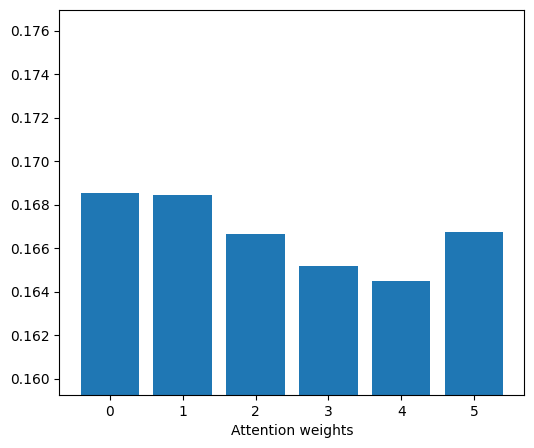

In [11]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(6, 5))
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights')

# zoom in
top = max(plt.ylim())
zoom = 0.85*top
plt.ylim([0.90*top, top])

plt.show()

## 3 - Decoder
The decoder generates the prediction for the next output token starting from the encoder output

1. it uses an RNN to keep track of what it has predicted previously
2. the RNN output is used as a query for the attention layer to attend the encoder's output and produce the context vector
3. the context vector is combined with the RNN output to generate the attention vector using the equation

$$\large{\boldsymbol{a}_t = \rm{tanh}(\boldsymbol{W}_c[\boldsymbol{c}_t; \boldsymbol{h}_t])}~~~~~\rm{[attention~vector]}$$

4. finally, it generates logit predictions for the next token based on the attention vector

In [12]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        """
        This class creates a new custom tf.keras.Layer. This is done by instantiating some variables and combining them.
        For more info see: https://www.tensorflow.org/guide/keras/custom_layers_and_models
        Here we instantiate all the layers that we need for this model. 
        Next, the `call` method creates the layer by combining the ones instantiated here.
        :param output_vocab_size:
        :param embedding_dim:
        :param dec_units:
        """
        super(Decoder, self).__init__()
        
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # Instantiate an embedding layer to convert token IDs to vectors
        ### START CODE HERE ###
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)
        ### END CODE HERE ###
        
        # Instantiate an RNN to keep track of what will be generated from time to time by the decoder
        ### START CODE HERE ###
        self.gru = tf.keras.layers.GRU(
                                    self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        ### END CODE HERE ###

        # Instantiate a BahdanauAttention layer that will obtain as input the RNN output, i.e., the RNN output will be the query to the attention layer over the encoder's output to produce the context vector
        ### START CODE HERE ###
        self.attention = BahdanauAttention(self.dec_units)
        ### END CODE HERE ###

        # Instantiate a Dense layer to combine the RNN output and the context vector to generate the attention vector
        ### START CODE HERE ###
        self.Wc = tf.keras.layers.Dense(self.dec_units, activation=tf.math.tanh, use_bias=False)
        ### END CODE HERE ###

        # Instantiate a fully connected layer to produce the logits for each output token based on the attention vector
        ### START CODE HERE ###
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        ### END CODE HERE ###

    def call(self, new_tokens, enc_output, mask, state=None):
        # Step 1. Lookup the embeddings
        ### START CODE HERE ###
        vectors = self.embedding(new_tokens)
        ### END CODE HERE ###

        # Step 2. Process one step with the RNN
        ### START CODE HERE ###
        rnn_output, state = self.gru(vectors, initial_state=state)
        ### END CODE HERE ###

        # Step 3. Use the RNN output as the query for the attention over the encoder output
        ### START CODE HERE ###
        context_vector, attention_weights = self.attention(query=rnn_output, value=enc_output, mask=mask)
        ### END CODE HERE ###

        # Step 4. Concatenate the context_vector and rnn_output -- shape: (batch t, value_units + query_units)
        ### START CODE HERE ###
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        ### END CODE HERE ###

        # Step 4. Obtain the attention vector: attention_vector = tanh(Wc@context_and_rnn_output)
        ### START CODE HERE ###
        attention_vector = self.Wc(context_and_rnn_output)
        ### END CODE HERE ###

        # Step 5. Generate logit predictions through the final dense layer
        ### START CODE HERE ###
        logits = self.fc(attention_vector)
        ### END CODE HERE ###

        return logits, attention_weights, state

Check the correct functioning of the decoder layer by running the cell below.

In [13]:
### START CODE HERE ###
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
### END CODE HERE ###
    
# Convert the target sequence using the output_text_processor object you instantiated above
### START CODE HERE ###
example_output_tokens = output_text_processor(example_target_batch)
### END CODE HERE ###

# Collect the "[START]" tokens
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

# Run the decoder
### START CODE HERE ###
dec_logits, dec_attention, dec_state = decoder(first_token, enc_output=example_enc_output, mask=(example_tokens != 0), state=example_enc_state)
### END CODE HERE ###

print(f'logits shape (batch_size, t, output_vocab_size): {dec_logits.shape}')
print(f'state shape (batch_size, dec_units): {dec_state.shape}')

sampled_token = tf.random.categorical(dec_logits[:, 0, :], num_samples=1)
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

logits shape (batch_size, t, output_vocab_size): (64, 1, 2619)
state shape (batch_size, dec_units): (64, 1024)


array([['snoring'],
       ['mess'],
       ['blind'],
       ['jittery'],
       ['thanks']], dtype='<U12')

## 4 - Loss function
Here we create a custom loss function that will be used during training for computing the gradients to be backpropagated and allow updating the weights. The construction is similar to the one seen for the custom layers above,
[see here for more info](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses).

In [14]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        """
        Here we create a custom loss function. The construction is similar to the one seen for the custom layers above.
        See https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses
        """
        super(MaskedLoss, self).__init__()
        
        self.name = 'masked_loss'
        
        ### START CODE HERE ###
        # Use the correct boolean for the from_logits argument
        # Use reduction='none' as you will compute the reduced sum in the __call__ method
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        ### END CODE HERE ###

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch
        ### START CODE HERE ###
        loss = self.loss(y_true, y_pred)
        ### END CODE HERE ###

        # Mask off the losses on padding
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total (use tf.reduce_sum)
        ### START CODE HERE ###
        return tf.reduce_sum(loss)
        ### END CODE HERE ###

Congratulations! You created all the building blocks to implement the sequence-to-sequence neural machine translator. Tomorrow you will create the network, train it and see it at work... ready? See you tomorrow :)